![](https://github.com/SauravMaheshkar/Tabular-Playground-Series-June-2021/blob/main/assets/TPS%20June%202021.png?raw=true)

# Table of Contents

1. [**Packages 📦 and Basic Setup**](#basic)
2. [**Pre-Processing 👎🏻 -> 👍**](#process)
3. [**The Model 👷‍♀️**](#model)
4. [**Training 💪🏻**](#train)

<a id = 'basic'> </a>
# Packages 📦 and Basic Setup

Initially introduced in the paper titled [**"TabNet: Attentive Interpretable Tabular Learning"**](https://arxiv.org/pdf/1908.07442.pdf), TabNet is a novel high-performance and interpretable canonical deep tabular data learning architecture. It uses sequential attention to choose which features to reason from at each decision step, enabling interpretability and more efficient learning as the learning capacity is used for the most salient features.

![](https://github.com/SauravMaheshkar/Tabular-Playground-Series-May-2021/blob/main/assets/tabnet.png?raw=true)

A Pytorch Implementation of Tabnet has been made available by the team at [**dreamquark-ai**](https://github.com/dreamquark-ai/tabnet). We can simply install the package using `pip`.
```
pip install pytorch-tabnet
```

This kernel aims to be a starter notebook for you to add your own pre-processing / parameters.

In [1]:
%%capture
!pip install pytorch-tabnet

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

train = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv")

<a id = 'process'></a>
# Pre-Processing 👎🏻 -> 👍

In [3]:
# Normalization
for i in range(75):
    mean, std = train[f'feature_{i}'].mean(), train[f'feature_{i}'].std()
    train[f'feature_{i}'] = train[f'feature_{i}'].apply(lambda x : (x-mean)/std)

We'll split the dataset into a **80-10-10 split** for training, validation and test respectively.

In [4]:
# Train, Test, Validation Split
target = 'target'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

Fill NaN values + **optional** script for object columns

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object':
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

target 9
Set 3


<a id = 'model'></a>
# The Model 👷‍♀️

In [6]:
# Columns not to use
unused_feat = ['Set']

# Features to Use
features = [ col for col in train.columns if col not in unused_feat+[target]] 

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [7]:
# Basic model parameters
max_epochs = 30
batch_size = 1024
opt = torch.optim.Adam # Optimizer
opt_params = dict(lr=1e-3)
sch = torch.optim.lr_scheduler.StepLR # LR Scheduler
sch_params = {"step_size":10, "gamma":0.9}
mask = 'entmax'
workers = 2 # For torch DataLoader
sample_type = 1 # For automated sampling with inverse class occurrences 
virtual_batch = 128 # Size of the mini batches used for "Ghost Batch Normalization"

The paper highlights a semi-supervised pre-training method which is available via the **`TabNetPretrainer`** class. We'll use this pretrain this model and use it to boost the tabnet model performance as a unsupervised prior.

In [8]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn = opt,
    optimizer_params = opt_params,
    mask_type = mask)

Device used : cpu


In [9]:
clf = TabNetClassifier(gamma = 1.5,
                       lambda_sparse = 1e-4,
                       optimizer_fn = opt,
                       optimizer_params = opt_params,
                       scheduler_fn = sch,
                       scheduler_params = sch_params,
                       mask_type = mask)

Device used : cpu


<a id = 'train'></a>
# Training 💪🏻

In [10]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    pretraining_ratio=0.8)

epoch 0  | loss: 2.15703 | val_0_unsup_loss: 1.16246 |  0:00:24s
epoch 1  | loss: 1.32068 | val_0_unsup_loss: 1.0884  |  0:00:49s
epoch 2  | loss: 1.11549 | val_0_unsup_loss: 1.06558 |  0:01:13s
epoch 3  | loss: 1.06661 | val_0_unsup_loss: 1.04843 |  0:01:37s
epoch 4  | loss: 1.05236 | val_0_unsup_loss: 1.04514 |  0:02:02s
epoch 5  | loss: 1.04408 | val_0_unsup_loss: 1.04248 |  0:02:26s
epoch 6  | loss: 1.04439 | val_0_unsup_loss: 1.0402  |  0:02:51s
epoch 7  | loss: 1.04013 | val_0_unsup_loss: 1.03906 |  0:03:15s
epoch 8  | loss: 1.03951 | val_0_unsup_loss: 1.03736 |  0:03:39s
epoch 9  | loss: 1.03838 | val_0_unsup_loss: 1.03626 |  0:04:03s
epoch 10 | loss: 1.0388  | val_0_unsup_loss: 1.03537 |  0:04:28s
epoch 11 | loss: 1.03642 | val_0_unsup_loss: 1.03469 |  0:04:52s
epoch 12 | loss: 1.03696 | val_0_unsup_loss: 1.03431 |  0:05:16s
epoch 13 | loss: 1.03615 | val_0_unsup_loss: 1.03222 |  0:05:40s
epoch 14 | loss: 1.03412 | val_0_unsup_loss: 1.03084 |  0:06:05s
epoch 15 | loss: 1.034   

In [11]:
clf.fit(X_train=X_train, 
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'val'],
    eval_metric=["logloss", 'balanced_accuracy'],
    max_epochs=max_epochs , patience=15,
    batch_size=batch_size,
    virtual_batch_size=virtual_batch,
    num_workers=workers,
    weights=sample_type,
    drop_last=False,
    from_unsupervised=unsupervised_model)

Loading weights from unsupervised pretraining
epoch 0  | loss: 2.22178 | train_logloss: 2.20217 | train_balanced_accuracy: 0.11348 | val_logloss: 2.2021  | val_balanced_accuracy: 0.10819 |  0:00:27s
epoch 1  | loss: 2.19877 | train_logloss: 2.19537 | train_balanced_accuracy: 0.11572 | val_logloss: 2.19561 | val_balanced_accuracy: 0.11085 |  0:00:54s
epoch 2  | loss: 2.19395 | train_logloss: 2.19106 | train_balanced_accuracy: 0.12674 | val_logloss: 2.1916  | val_balanced_accuracy: 0.12707 |  0:01:21s
epoch 3  | loss: 2.18974 | train_logloss: 2.18342 | train_balanced_accuracy: 0.12939 | val_logloss: 2.18419 | val_balanced_accuracy: 0.12972 |  0:01:49s
epoch 4  | loss: 2.18512 | train_logloss: 2.17325 | train_balanced_accuracy: 0.13031 | val_logloss: 2.17439 | val_balanced_accuracy: 0.1301  |  0:02:16s
epoch 5  | loss: 2.1814  | train_logloss: 2.16494 | train_balanced_accuracy: 0.13112 | val_logloss: 2.16612 | val_balanced_accuracy: 0.13144 |  0:02:43s
epoch 6  | loss: 2.17878 | train_log

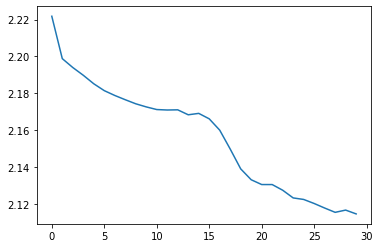

In [12]:
# plot losses
plt.plot(clf.history['loss'])

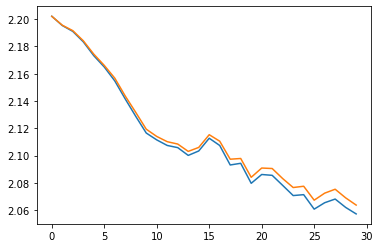

In [13]:
# plot auc
plt.plot(clf.history['train_logloss'])
plt.plot(clf.history['val_logloss'])

# Submission

In [14]:
test = pd.read_csv('../input/tabular-playground-series-jun-2021/test.csv')
test_indices = test.index
test_ds = test[features].values[test_indices]

sample_submission = pd.read_csv('../input/tabular-playground-series-jun-2021/sample_submission.csv')
sample_submission[['Class_1','Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']] = clf.predict_proba(test_ds)
sample_submission.to_csv('tabnet_submission.csv',index = False)

In [15]:
sample_submission.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.105013,0.030583,0.050177,0.097657,0.123886,0.137601,0.163162,0.190370,0.101550
1,200001,0.105300,0.028524,0.047995,0.099514,0.128135,0.119248,0.171339,0.198611,0.101334
2,200002,0.103851,0.026284,0.045370,0.113098,0.124386,0.135002,0.158669,0.206280,0.087061
3,200003,0.107621,0.045044,0.063346,0.135358,0.131953,0.097157,0.138374,0.172204,0.108943
4,200004,0.116302,0.037413,0.060385,0.121318,0.135423,0.092812,0.157834,0.176246,0.102267
